In [14]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

샘플링 속도: 5000.05 Hz
추정 주기당 샘플 수 (distance): 369
자동 추정 height: 8.427 μA
피크 개수: 162
평균 주파수: 8.07 Hz


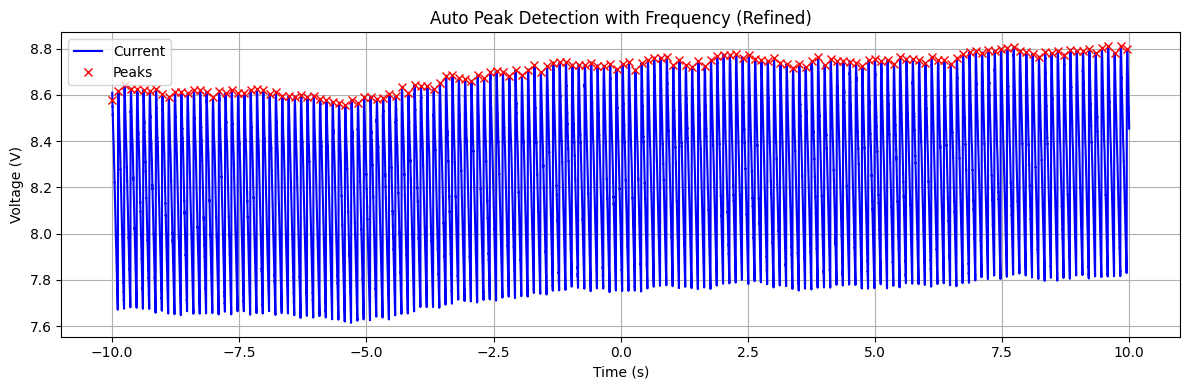

In [116]:
# CSV 파일 경로 지정
file_path = r"C:\Users\GCU\Downloads\tek0000ALL.csv"

# 데이터 로드
df = pd.read_csv(file_path, header=None, names=["Time", "Current"], skiprows = 30)
time = df["Time"].values
current = df["Current"].values

# 샘플링 속도 추정
total_time = time[-1] - time[0]
sampling_rate = len(time) / total_time

# -------------------------------
# 1차 감지: 보수적으로 명확한 피크만 찾음
mean_val = np.mean(current)
std_val = np.std(current)
rough_height = mean_val + 0.2* std_val  # ← 좀 더 보수적으로 감지

rough_peaks, _ = find_peaks(current, height=rough_height, distance=int(sampling_rate * 0.05))  # 최소 5ms 이상 간격

rough_peak_times = time[rough_peaks]
rough_periods = np.diff(rough_peak_times)

# 중간값 기반 주기 추정
if len(rough_periods) == 0:
    raise ValueError("피크가 너무 적게 감지되어 주기 추정을 못 함")

estimated_period = np.median(rough_periods)
estimated_cycle_len = int(estimated_period * sampling_rate)
# -------------------------------

# 2차 감지용 height (자동)
final_height = mean_val + 0.6* std_val

# -------------------------------
# 2차 피크 감지
peaks, _ = find_peaks(current, height=final_height, distance=estimated_cycle_len)
# -------------------------------

# 결과 계산
peak_times = time[peaks]
periods = np.diff(peak_times)
frequencies = 1 / periods
mean_frequency = np.mean(frequencies) if len(frequencies) > 0 else 0

# 출력
print(f"샘플링 속도: {sampling_rate:.2f} Hz")
print(f"추정 주기당 샘플 수 (distance): {estimated_cycle_len}")
print(f"자동 추정 height: {final_height:.3f} μA")
print(f"피크 개수: {len(peaks)}")
print(f"평균 주파수: {mean_frequency:.2f} Hz")

# 시각화
plt.figure(figsize=(12, 4))
plt.plot(time, current, label='Current', color='blue')
plt.plot(peak_times, current[peaks], 'rx', label='Peaks')
plt.title("Auto Peak Detection with Frequency (Refined)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()